# "(DRAFT) Imbalanced Data and Bags of Logistic Regressions"

> Experiments with three different strongly-imbalanced datasets.

- toc: true
- branch: master
- badges: false
- comments: true
- categories: [imbalanced, supervised-learning]
- image: images/UPDATEME.png
- hide: false
- search_exclude: false
- annotations: true

In [1]:
#collapse
import pickle
from collections import defaultdict
from itertools import product

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

from imblearn.datasets import fetch_datasets
from imblearn.ensemble import BalancedRandomForestClassifier, BalancedBaggingClassifier
from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.pipeline import make_pipeline

from sklearn.datasets import make_blobs
from sklearn.model_selection import cross_validate, cross_val_predict, StratifiedKFold
from sklearn.metrics import precision_recall_curve
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

## Introduction

Imbalanced datasets occur in many different fields and create unique challenges in model training as well as evaluation. In this post, we compare a few different algorithms on imbalanced datasets. We delve deeper on a specific ensemble model: a bag of logistic regressions, and discuss why it might be a good choice for many imbalanced datasets. 

## Datasets

We use three datasets from different domains. All three are available from the UCI ML Database. An overview of their properties is provided below.

In [6]:
#collapse
datasets = fetch_datasets(filter_data=('ozone_level', 'coil_2000'))

abalone_uci = 'http://archive.ics.uci.edu/ml/machine-learning-databases/abalone/abalone.data'
abalone = pd.read_csv(abalone_uci, header=None)
abalone.columns = ['sex', 'length', 'diameter', 'height', 'whole_weight', 'shucked_weight', 
                   'viscera_weight', 'shell_weight', 'rings']
abalone = pd.get_dummies(abalone, columns=['sex'])

In [2]:
#collapse
def abalone_Xy(thr=15):
    return {
        'data': abalone.drop(columns='rings'),
        'target': (abalone['rings'] >= thr).astype(np.int32),
        'DESCR': f'abalone_{thr}+'
    }

def get_stats(ds):
    """Extract statistics from a dataset."""
    n_examples, n_feats = ds['data'].shape
    is_positive = ds['target'] == 1
    return {
        'name': ds['DESCR'],
        'n_examples': n_examples,
        'n_feats': n_feats,
        'prop_positive': is_positive.mean(),
        'n_positive': is_positive.sum()
    }

datasets['abalone_19+'] = abalone_Xy(thr=19)

ds_info = pd.DataFrame(get_stats(ds) for ds in datasets.values())
ds_info

### Ozone level

This dataset contains 7 years of metereological (wind speed, temperature) as well as air quality indicators for Houson, Texas. The goal is to predict "ozone days" - days when the ground-level ozone concentration exceeds a certain threshold, which can be harmful to human health. 

<img class="docimage" src="../images/houston_pollution.jpg" alt="Houston pollution" style="max-width: 40%"/>

### Coil 2000

This is an insurance dataset where the goal is to predict which customer of a Dutch insurance company owns an insurance policy covering a caravan. The features include socio-demographic data (derived from postal codes) and product ownership datas. Importantly, all continuous features have been discretized in advance by the company. 

* drop demographic except MKOOPKLA
* add extra features?

### Abalone

## Experiments

### Models

Dealing with imbalanced datasets often involves resampling. For example, we can under-sample the majority class, over-sample the minority class, or do a combination of the two. There are also methods that over-sample based on specific rules, which might involve generating synthetic new examples. e.g., see the family of SMOTE methods in the [imbalanced-learn](https://imbalanced-learn.org/stable/references/over_sampling.html) library.

Bagging methods can be a particularly good fit for imbalanced datasets because resampling is already part of the algorithm. So all we need to do is to modify the resampling procedure to introduce some rebalancing of the dataset. This is already implemented for us in `imblearn.ensemble`. For example, a `BalancedRandomForestClassifier(sampling_strategy=0.5)` is similar to a regular Random Forest, but each tree will be fitted to a rebalanced dataset, where the ratio of minority- to majority-class samples is 0.5

The models we use are:
* Balanced Bag of Logistic Regressions
* Balanced Random Forest (or a Bag of Trees)

We discuss the first choice in more detail in the next section.

In [7]:
def get_clfs(sampling_strategy, max_features=0.5):
    return {
        'logistic_bag': make_pipeline(
            StandardScaler(),
            BalancedBaggingClassifier(
                base_estimator=LogisticRegression(penalty='l2'), 
                sampling_strategy=sampling_strategy,
                max_features=max_features, 
                n_estimators=20,
            )
        ),
        'balanced_forest': BalancedRandomForestClassifier(
            min_samples_split=10, 
            sampling_strategy=sampling_strategy,
            n_estimators=100,
            max_features=max_features)
    }

In [16]:
#collapse
def run_exp(ds, clf, seed=42):
    """Given a dataset ds and classifier clf, run a cross-validation experiment."""
    X, y = ds['data'], ds['target']
    cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=seed)
    scores = cross_validate(clf, X, y, cv=cv, n_jobs=-1,
                            scoring=['balanced_accuracy', 'f1', 'precision', 'recall'])
    y_probs = cross_val_predict(clf, X, y, method='predict_proba', cv=cv, n_jobs=-1)[:, 1]
    scores['y_probs'] = y_probs
    return scores

def plot_precision_recall(y_true, y_probs, ax=None, **plot_kwargs):
    ax = ax or plt.gca()
    prec, recall, thr = precision_recall_curve(y_true, y_probs)
    ax.plot(recall, prec, **plot_kwargs)
    ax.set_ylabel('Precision', fontsize=12)
    ax.set_xlabel('Recall', fontsize=12)
    return ax

In [48]:
def get_linear_model(clf, i):
    estimators = clf.named_steps['balancedbaggingclassifier'].estimators_
    return estimators[0].named_steps['classifier']

In [59]:
results = defaultdict(dict)
for (ds_name, ds), (clf_name, clf) in tqdm(product(datasets.items(), clfs.items()),
                                           total=len(datasets) * len(clfs)):
    results[ds_name][clf_name] = run_exp(ds, clf)

100%|██████████| 6/6 [00:27<00:00,  4.60s/it]


In [12]:
with open('base_results.pickle', 'wb') as f:
    pickle.dump(results, f)

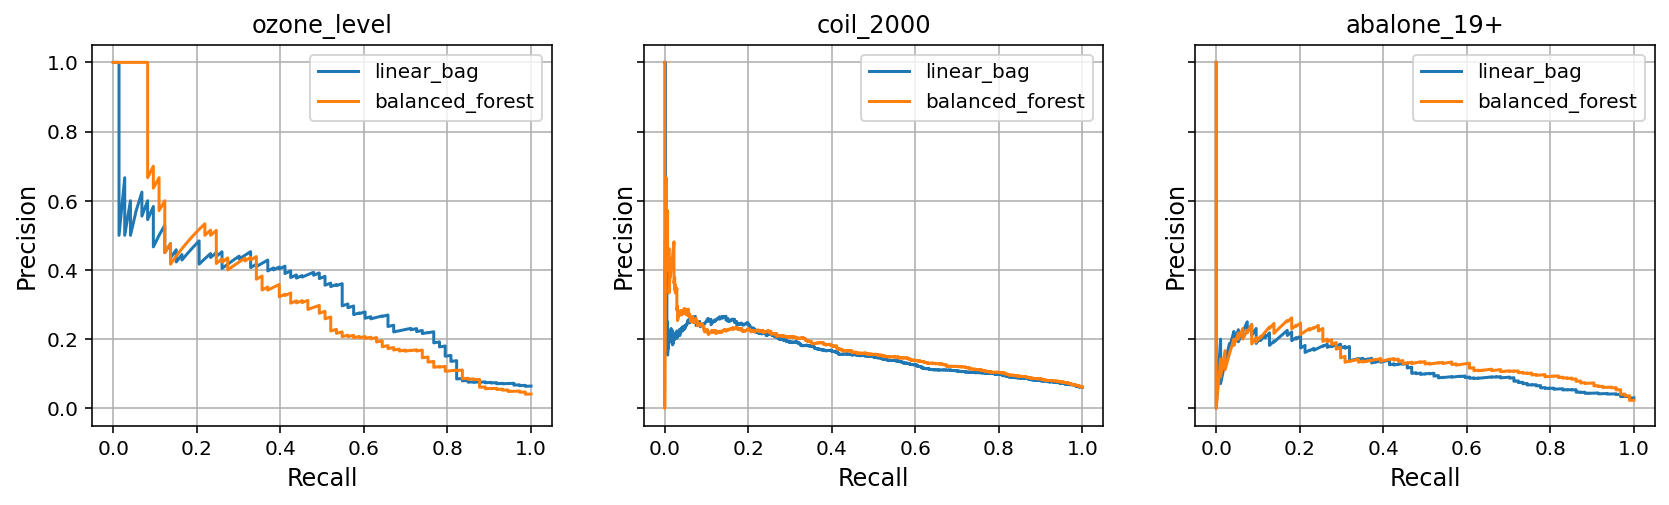

In [56]:
#collapse
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(14, 3.5), sharey=True)
for i, (ds_name, ds_dict) in enumerate(results.items()):
    ax = axes[i]
    y_true = datasets[ds_name]['target']
    for clf_name, res in ds_dict.items():
        ax = plot_precision_recall(y_true, res['y_probs'], ax=ax, label=clf_name)
    ax.set_title(ds_name)
    ax.legend()
    ax.grid(True)

## Bag of logistic regressions

The bag of logistic regressions might not be an obvious choice, but it performed quite well in this experiment. So it is worth spending a moment to consider why it might work so well.

### Isn't a bag of linear models simply a linear model?

It depends on the linear model, and how the individual models' predictions are combined in the bag. Indeed, for regression problems, a bag of linear regressions will produce another linear model. Logistic regression, however, includes a link function:

$$p_i(x) = \frac {1}{1+e^{-\mathbf{w x_i}}}$$

where $\mathbf{w}$ is the vector of weights fitted in the model, and $p_i$ is the predicted probability for example $x_i$.

In a BaggingClassifier, we are averaging the predicted probabilities of the base models - basically it uses the predict_proba method averages these together. For example, with two models, we obtain: 

$$p_{i, bag}(x) = \frac{p_{i, 1} + p_{i, 2}}{2} = \frac{1}{2} [\frac {1}{1+e^{-\mathbf{w_1 x_i}}} + \frac {1}{1+e^{-\mathbf{w_2 x_i}}}]$$

This combination of $p_i$ will not necessarily produce a linear decision boundary. We can also create a toy example to illustrate this.

In [8]:
#collapse
def make_imbalanced_blobs(n_positive, n_negative=400, randon_state=0):
    """Creates a synthetic dataset with four blobs, where the blob at
    (0, 0) is the negative class.
    
    By setting n_positive to a small number, we can create an imbalanced dataset.
    """
    centers = [(0, 0), (5, 5), (5, -5), (-5, 5)]
    total = n_negative * len(centers)
    assert n_positive + n_negative <= total, f'n_positive + n_negative exceeds total {total}'
    X, y_blob = make_blobs(n_samples=n_negative * len(centers), centers=centers, 
                           shuffle=False, random_state=randon_state)
    X_center = X[y_blob == 0]  # negative class
    X_side   = X[y_blob != 0]  # positive class before resampling
    sample = np.random.choice(len(X_side), size=n_positive, replace=False)
    X_side = X_side[sample]

    X = np.concatenate([X_center, X_side])
    y = np.concatenate([np.zeros(len(X_center), dtype=int), 
                        np.ones(len(X_side),    dtype=int)])
    return X, y

def plot_blobs_with_boundaries(clfs, X, y):
    """Plots the decision boundaries for classifiers clfs, given 
    a blobs dataset. One plot for each classifier is created.
    """
    for clf in clfs.values(): clf.fit(X, y)

    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                         np.arange(y_min, y_max, 0.1))

    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))

    for ax, (clf_name, clf) in zip(axes, clfs.items()):
        Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]
        Z = Z.reshape(xx.shape)
        ax.contourf(xx, yy, Z, alpha=0.4)
        ax.scatter(X[:, 0], X[:, 1], c=y, s=20, edgecolor='black')
        ax.set_title(clf_name)

Let's first plot the case where the dataset is fairly balanced.

In [ ]:
X, y = make_imbalanced_blobs(n_positive=200)
plot_blobs_with_boundaries(get_clfs(sampling_strategy='auto', max_features=1), X, y)

In [ ]:
We can see that the lo

In [ ]:
X, y = make_imbalanced_blobs(n_positive=20)
plot_blobs_with_boundaries(get_clfs(sampling_strategy=0.1, max_features=1), X, y)

### Why use bagging with a logistic regression as it is a low-variance estimator? 

In [14]:
min_thr, max_thr = 10, 19
abalone_res = {thr: run_exp(abalone_Xy(thr), clfs['linear_bag'])
               for thr in range(max_thr, min_thr - 1, -1)}

In [41]:
def thr_to_color(thr):
    return plt.cm.viridis((thr - min_thr) / (max_thr - min_thr))

In [42]:
thr_to_color(19), thr_to_color(10)

((0.993248, 0.906157, 0.143936, 1.0), (0.267004, 0.004874, 0.329415, 1.0))

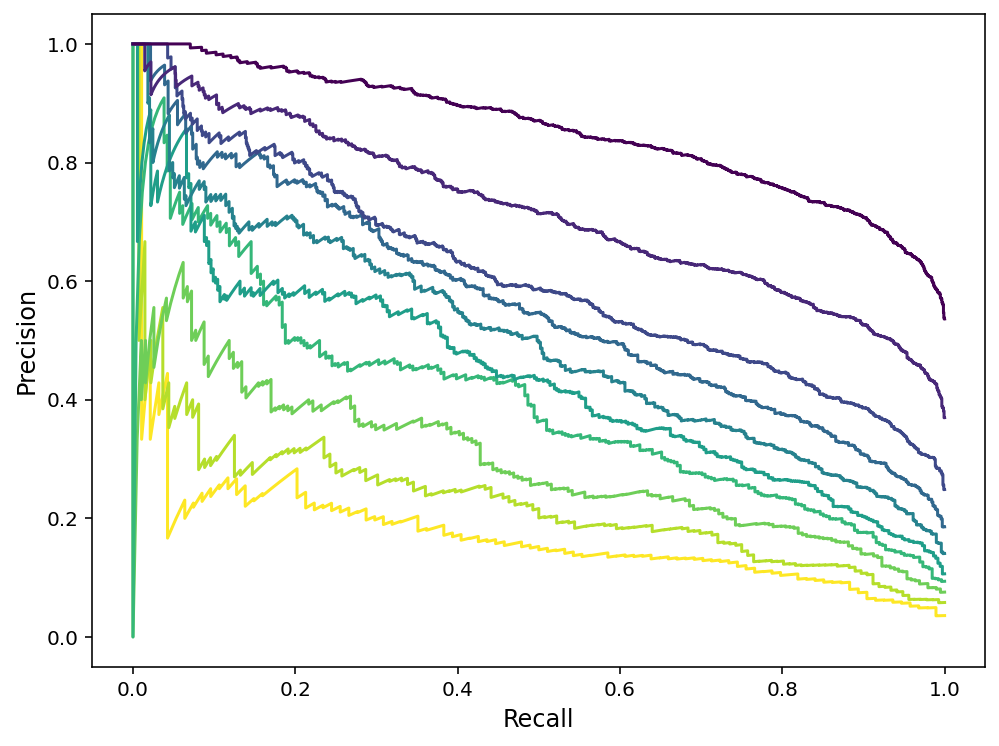

In [43]:
fig, ax = plt.subplots(figsize=(8, 6))

for thr, res in abalone_res.items():
    y_true = abalone_Xy(thr)['target']
    plot_precision_recall(y_true, res['y_probs'], ax=ax, label=thr, color=thr_to_color(thr))

## Conclusion 

## References and resources 